# COPD Classification

In [1]:
!pip install wave pandas numpy matplotlib librosa tensorflow seaborn tqdm

  Preparing metadata (setup.py) ... done
  Created wheel for wave: filename=Wave-0.0.2-py3-none-any.whl size=1220 sha256=f4aaa958bc1e566bfd4682d8a4be806f6e35b053de3cdf206c25d83398e7262f
  Stored in directory: /root/.cache/pip/wheels/f8/24/4d/1b01c0e32da3eb3fd71bbbc6093fcc557ec3b2d9e532ecd65d
Successfully built wave


## Download the datasets

In [ ]:
#!wget --no-check-certificate https://bhichallenge.med.auth.gr/sites/default/files/ICBHI_final_database/ICBHI_final_database.zip

--2024-12-13 13:32:46--  https://bhichallenge.med.auth.gr/sites/default/files/ICBHI_final_database/ICBHI_final_database.zip
Resolving bhichallenge.med.auth.gr (bhichallenge.med.auth.gr)... 155.207.200.92
Connecting to bhichallenge.med.auth.gr (bhichallenge.med.auth.gr)|155.207.200.92|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 1978998275 (1.8G) [application/zip]
Saving to: ‘ICBHI_final_database.zip’

ICBHI_final_databas 100%[===================>]   1.84G  14.9MB/s    in 2m 10s  

2024-12-13 13:34:58 (14.5 MB/s) - ‘ICBHI_final_database.zip’ saved [1978998275/1978998275]



แตกไฟล์ zip และบันทึกลง Google Drive ตนเอง

In [ ]:
# import zipfile
# import os

# # Specify the path to the zip file
# zip_file_path = '/content/ICBHI_final_database.zip'

# # Specify the directory to extract the zip file to. Replace with your desired directory.
# extract_dir = '/content/drive/MyDrive/ICBHI_final_database' # Example path in Google Drive

# # Create the extraction directory if it doesn't exist
# os.makedirs(extract_dir, exist_ok=True)

# # Extract the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)
# print(f"Successfully extracted '{zip_file_path}' to '{extract_dir}'")

Successfully extracted '/content/ICBHI_final_database.zip' to '/content/drive/MyDrive/ICBHI_final_database'


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## EDA (Exploratory data analysis)

In [3]:
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

In [4]:
dataset_path = "/content/drive/MyDrive/ICBHI_final_database/"

## อ่านไฟล์ demographic_info (ประวัติผู้ป่วย)

In [5]:
df_no_diagnosis = pd.read_csv(dataset_path + "demographic_info.txt", names =
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'], delimiter = ' ')

diagnosis = pd.read_csv(dataset_path + "patient_diagnosis.csv", names = ['Patient number', 'Diagnosis'])

In [6]:
df_no_diagnosis.head(10)

Patient number    Age Sex  Adult BMI (kg/m2)  Child Weight (kg)  \
0             101   3.00   F                NaN               19.0   
1             102   0.75   F                NaN                9.8   
2             103  70.00   F              33.00                NaN   
3             104  70.00   F              28.47                NaN   
4             105   7.00   F                NaN               32.0   
5             106  73.00   F              21.00                NaN   
6             107  75.00   F              33.70                NaN   
7             108   3.00   M                NaN                NaN   
8             109  84.00   F              33.53                NaN   
9             110  75.00   M              25.21                NaN   

   Child Height (cm)  
0               99.0  
1               73.0  
2                NaN  
3                NaN  
4              135.0  
5                NaN  
6                NaN  
7                NaN  
8                NaN  
9                NaN

In [7]:
df_no_diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient number     126 non-null    int64  
 1   Age                125 non-null    float64
 2   Sex                125 non-null    object 
 3   Adult BMI (kg/m2)  75 non-null     float64
 4   Child Weight (kg)  44 non-null     float64
 5   Child Height (cm)  42 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 6.0+ KB


จากข้อมูลของประวัติคนไข้สามารถพบได้ว่า ถ้าหากมีข้อมูล BMI จะไม่มีช่องน้ำหนักและความสูง ในขณะที่ถ้ามันมี น้ำหนักความสูง ก็จะไม่มี BMI

## ทำการดู Label วินิจฉัย

In [8]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

Diagnosis
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: count, dtype: int64

Note : จากการสังเกตการณ์พบว่า มีเพียง 64 คนที่เป็น COPD และ Healthy 26 คน ฉะนั้นตรงนี้เป็นปัญหาหลักในการทำ Classification เนื่องจากเป็น ปัญหา Imbalanced Datasets

Note :

* COPD คือ โรคหลอดลมอุดกั้นเรื้อรัง
โรคหลอดลมอุดกั้นเรื้อรัง (COPD) เป็น โรคปอดชนิดเรื้อรังที่ผู้ป่วยจะมีพยาธิสภาพของถุงลมโป่งพองและ/หรือหลอดลมอักเสบเรื้อรังเกิดร่วมกัน

* URTI คือ โรคติดเชื้อระบบทางเดินหายใจส่วนบน (Upper respiratory tractinfection ย่อว่า URI) เป็นการติดเชื้อเฉียบพลันของระบบหายใจส่วนต้น คือ ตั้งแต่ช่องจมูกจนถึงช่องกล่องเสียง โรคที่จัดอยู่ในกลุ่มของ URI
ที่พบบ่อย ได้แก่
ไข้หวัด
ช่องหูส่วนกลางอักเสบเฉียบพลัน
การอักเสบเฉียบพลันของโพรงจมูก
คออักเสบเฉียบพลัน
ต่อมทอลซิลอักเสบเฉียบพลัน

ฉะนั้นเราจะลด Label ให้เหลือเฉพาะ Healthy and COPD


## ประกาศ Directory ของ Audio และ Text

In [9]:
root = dataset_path + 'audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

ฟังก์ชันสำหรับแยก file_names และ Match มาเป็น Dataframe

In [10]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

## คำอธิบาย Data Annotations ต่าง ๆ :

* Recording_info -> หมายถึงการนำชื่อไฟล์มาแยกเป็น Columns ตามนี้ 'Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'

Note : Acquisition mode คือโหมดในการบันทึว่าเป็น single channel หรือ multichannel


* Recording_annotations -> คือการอ่านไฟล์ txt กำกับของแต่ละการบันทึก โดยที่แบ่งเป็น 4 Columns ได้แก่ 'Start', 'End', 'Crackles', 'Wheezes'

ก็คือ ระยะเวลาที่มีการหายใจ พร้อมทั้งบอกด้วยว่าในการหายใจนั้นมีอาการ Crackles and Wheezes รึเปล่า


In [11]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.tail()

Patient number Recording index Chest location Acquisition mode  \
0            159             1b1             Ll               sc   
0            160             1b2             Ar               mc   
0            160             1b2             Tc               mc   
0            160             1b4             Ar               mc   
0            160             1b3             Al               mc   

  Recording equipment  
0            Meditron  
0            AKGC417L  
0            AKGC417L  
0            AKGC417L  
0            AKGC417L

In [12]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [13]:
file_label_df = pd.DataFrame(data = {'filename':filename_list})
file_label_df

filename
0    160_1b3_Pl_mc_AKGC417L
1    160_1b3_Lr_mc_AKGC417L
2    160_1b3_Tc_mc_AKGC417L
3    160_1b4_Al_mc_AKGC417L
4    160_1b3_Pr_mc_AKGC417L
..                      ...
915  159_1b1_Ll_sc_Meditron
916  160_1b2_Ar_mc_AKGC417L
917  160_1b2_Tc_mc_AKGC417L
918  160_1b4_Ar_mc_AKGC417L
919  160_1b3_Al_mc_AKGC417L

[920 rows x 1 columns]

In [14]:
audio_path = dataset_path + 'audio_and_txt_files/'

# adding columns in file_label_df
diagnosis = []
patient_number = []
recording_index = []
chest_location = []
acquisition_mode = []
recording_equipment = []
sample_rate = []
duration = []

for i in tqdm(range(len(file_label_df['filename']))):
  info = file_label_df['filename'][i].split('_')
  patient_id, recording_idx, chest_loc, acq_mode, equipment = info
  #sound_filename = audio_path + file_label_df['filename'][i] + '.wav'
  #x, sr = librosa.load(sound_filename)
  #dur = round(x.shape[0]/sr, 2)
  #sample_rate.append(sr)
  #duration.append(dur)

  diagnosis.append(df['Diagnosis'][int(patient_id) - 101])
  patient_number.append(patient_id)
  recording_index.append(recording_idx)
  chest_location.append(chest_loc)
  acquisition_mode.append(acq_mode)
  recording_equipment.append(equipment)

file_label_df['Diagnosis'] = diagnosis
file_label_df['Patient Number'] = patient_number
file_label_df['Chest Location'] = chest_location
file_label_df['Acquisition Mode'] = acquisition_mode
file_label_df['Recording Equipment'] = recording_equipment
#file_label_df['duration'] = duration
#file_label_df['sample rate'] = sample_rate

  0%|          | 0/920 [00:00<?, ?it/s]

In [15]:
file_label_df

filename Diagnosis Patient Number Chest Location  \
0    160_1b3_Pl_mc_AKGC417L      COPD            160             Pl   
1    160_1b3_Lr_mc_AKGC417L      COPD            160             Lr   
2    160_1b3_Tc_mc_AKGC417L      COPD            160             Tc   
3    160_1b4_Al_mc_AKGC417L      COPD            160             Al   
4    160_1b3_Pr_mc_AKGC417L      COPD            160             Pr   
..                      ...       ...            ...            ...   
915  159_1b1_Ll_sc_Meditron   Healthy            159             Ll   
916  160_1b2_Ar_mc_AKGC417L      COPD            160             Ar   
917  160_1b2_Tc_mc_AKGC417L      COPD            160             Tc   
918  160_1b4_Ar_mc_AKGC417L      COPD            160             Ar   
919  160_1b3_Al_mc_AKGC417L      COPD            160             Al   

    Acquisition Mode Recording Equipment  
0                 mc            AKGC417L  
1                 mc            AKGC417L  
2                 mc            AKGC417L  
3                 mc            AKGC417L  
4                 mc            AKGC417L  
..               ...                 ...  
915               sc            Meditron  
916               mc            AKGC417L  
917               mc            AKGC417L  
918               mc            AKGC417L  
919               mc            AKGC417L  

[920 rows x 6 columns]

In [16]:
diagnosis_3 = []
for i in range(len(file_label_df['Diagnosis'])):
  diagnosis = file_label_df['Diagnosis'][i]
  if diagnosis == 'COPD' or diagnosis == 'Bronchiectasis' or diagnosis == 'Asthma':
    diagnosis_3.append('Chronic Disease')
  elif diagnosis == 'URTI' or diagnosis == 'LRTI' or diagnosis == 'Pneumonia' or diagnosis == 'Bronchiolitis':
    diagnosis_3.append('Non-Chronic Disease')
  else:
    diagnosis_3.append('normal')

file_label_df['3 label diagnosis'] = diagnosis_3

## ลบให้เหลือเฉพาะ COPD และ Healthy

In [17]:
file_label_df['Diagnosis'].value_counts()

Diagnosis
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: count, dtype: int64

# Exploratory Data Analysis

In [18]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
import soundfile
from scipy.io.wavfile import read

In [19]:
i = 100
sound_filename = audio_path + file_label_df['filename'][i] + '.wav'

In [20]:
import IPython.display as ipd
ipd.Audio(sound_filename, rate=16000)

Text(0.5, 0.98, 'Display of sound in varies domain')

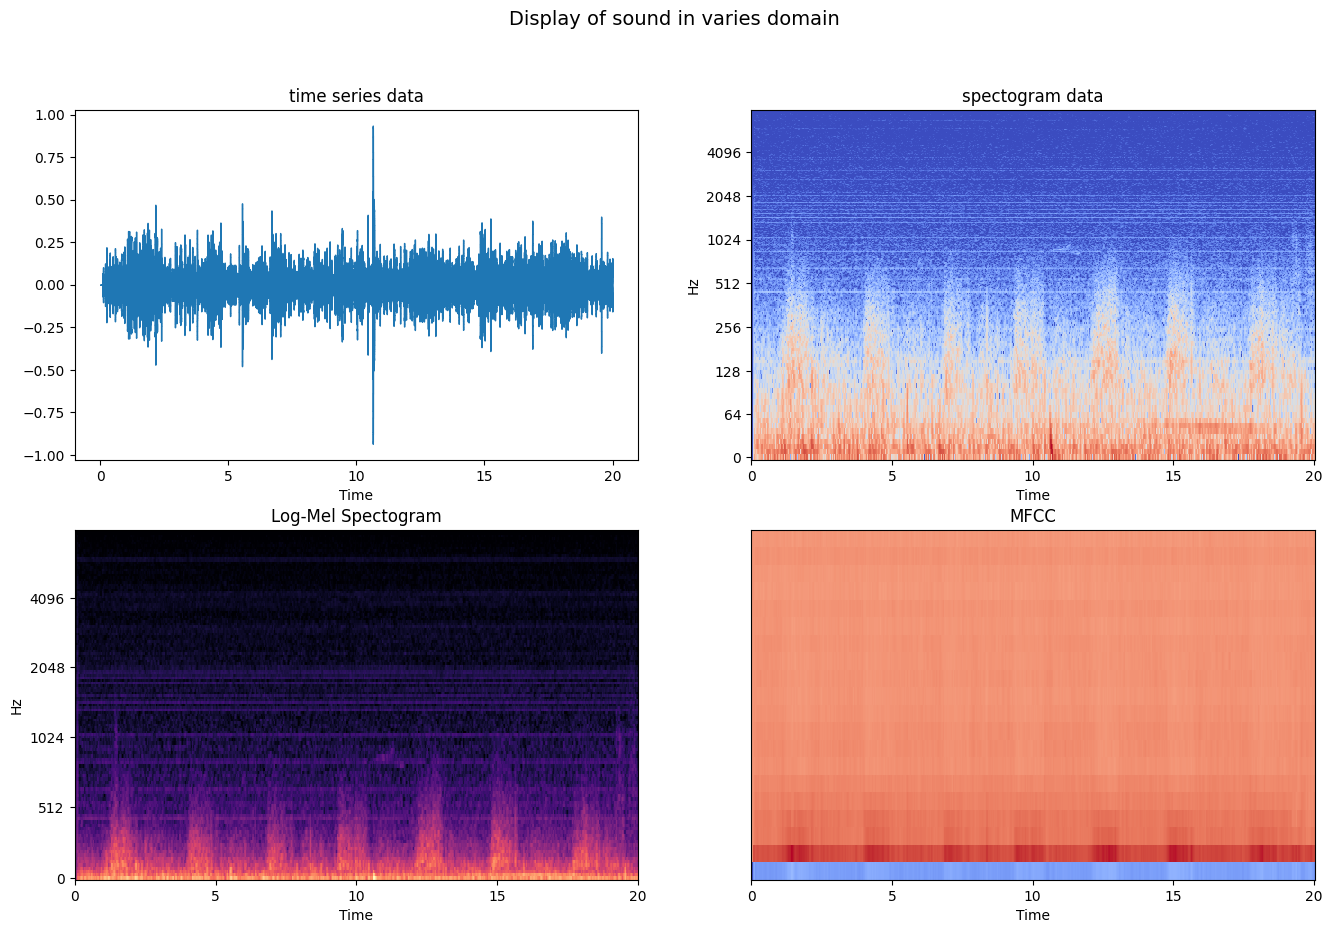

In [21]:
# Displaying sound data
"""
  time series : amplitude of sound is varied in time domain (1D)
  spectogram : amplitude of sound is varied in time and frequency domain (2D)
"""
# time series data
sr_new = 16000 # resample 16 kHz
x, sr = librosa.load(sound_filename, sr=sr_new) # x : time series data, sr : sample rate

# Spectogram data
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))

# Log-mel spectogram
mel = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=8000)
log_mel = librosa.power_to_db(mel, ref=np.max)


# Mel-Frequency Cepstral Coefficient (MFCC)
mfccs = librosa.feature.mfcc(y=x, sr=sr)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

librosa.display.waveshow(y=x, sr=sr, ax=ax[0, 0])
ax[0, 0].set(title='time series data')

librosa.display.specshow(Xdb, x_axis='time',
                         y_axis='log', sr=sr, ax=ax[0, 1])
ax[0, 1].set(title='spectogram data')

librosa.display.specshow(log_mel, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[1, 0])
ax[1, 0].set(title='Log-Mel Spectogram')


librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax[1, 1])
ax[1, 1].set(title='MFCC')

plt.suptitle("Display of sound in varies domain", fontsize=14)

## Preprocessing

Filtering the diagnosis only for "Healthy" and "COPD"

In [22]:
# Filter the DataFrame to include only 'Healthy' and 'COPD' diagnoses
file_label_df = file_label_df[file_label_df['Diagnosis'].isin(['Healthy', 'COPD'])]

# Display the filtered DataFrame
file_label_df

filename Diagnosis Patient Number Chest Location  \
0    160_1b3_Pl_mc_AKGC417L      COPD            160             Pl   
1    160_1b3_Lr_mc_AKGC417L      COPD            160             Lr   
2    160_1b3_Tc_mc_AKGC417L      COPD            160             Tc   
3    160_1b4_Al_mc_AKGC417L      COPD            160             Al   
4    160_1b3_Pr_mc_AKGC417L      COPD            160             Pr   
..                      ...       ...            ...            ...   
915  159_1b1_Ll_sc_Meditron   Healthy            159             Ll   
916  160_1b2_Ar_mc_AKGC417L      COPD            160             Ar   
917  160_1b2_Tc_mc_AKGC417L      COPD            160             Tc   
918  160_1b4_Ar_mc_AKGC417L      COPD            160             Ar   
919  160_1b3_Al_mc_AKGC417L      COPD            160             Al   

    Acquisition Mode Recording Equipment 3 label diagnosis  
0                 mc            AKGC417L   Chronic Disease  
1                 mc            AKGC417L   Chronic Disease  
2                 mc            AKGC417L   Chronic Disease  
3                 mc            AKGC417L   Chronic Disease  
4                 mc            AKGC417L   Chronic Disease  
..               ...                 ...               ...  
915               sc            Meditron            normal  
916               mc            AKGC417L   Chronic Disease  
917               mc            AKGC417L   Chronic Disease  
918               mc            AKGC417L   Chronic Disease  
919               mc            AKGC417L   Chronic Disease  

[828 rows x 7 columns]

In [23]:
def preprocessing(audio_file, mode):
    # we want to resample audio to 16 kHz
    sr_new = 16000 # 16kHz sample rate
    x, sr = librosa.load(audio_file, sr=sr_new)

    # padding sound
    # because duration of sound is dominantly 20 s and all of sample rate is 22050
    # we want to pad or truncated sound which is below or above 20 s respectively
    max_len = 5 * sr_new  # length of sound array = time x sample rate
    if x.shape[0] < max_len:
      # padding with zero
      pad_width = max_len - x.shape[0]
      x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
      # truncated
      x = x[:max_len]

    if mode == 'mfcc':
      feature = librosa.feature.mfcc(y=x, sr=sr_new)

    elif mode == 'log_mel':
      feature = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
      feature = librosa.power_to_db(feature, ref=np.max)

    return feature

In [24]:
# apply preprocessing to sound data

labels = []
preprocessed_data = []
for index, row in tqdm(file_label_df.iterrows()):  # Iterate through rows with index
  labels.append(row['Diagnosis'])  # Access 'Diagnosis' from the row
  audio_file = audio_path + row['filename'] + '.wav'  # Access 'filename' from the row
  data = preprocessing(audio_file, mode = 'mfcc')
  preprocessed_data.append(data)
preprocessed_data = np.array(preprocessed_data)
labels = np.array(labels)

0it [00:00, ?it/s]

In [37]:
labels

array(['COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'Healthy',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
   

In [26]:
preprocessed_data[0].shape

(20, 157)

In [27]:
# Reshape data to suit input of model
preprocessed_data = preprocessed_data.reshape((-1, 20, 157, 1))

In [29]:
# one hot encoding labels
encoder = LabelEncoder()
i_labels = encoder.fit_transform(labels)
oh_labels = to_categorical(i_labels,num_classes=2)

In [31]:
type(oh_labels)

numpy.ndarray

In [32]:
print(list(encoder.classes_))

['COPD', 'Healthy']


In [33]:
unique_values, counts = np.unique(oh_labels, return_counts=True)

# Display unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0.0, Count: 828
Value: 1.0, Count: 828


In [78]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, oh_labels,
                                                    test_size=0.2, random_state = 42)

In [79]:
print("size of training set= ",len(x_train))
print("size of testing set= ",len(x_test))

size of training set=  662
size of testing set=  166


In [80]:
oh_labels.shape

(828, 2)

## Let's not dealing with the highly imbalanced datasets first.

In [81]:
num_rows = 20
num_columns = 157
num_channels = 1


num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 19, 156, 16)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 9, 78, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 9, 78, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 9, 78, 64)           │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 8, 77, 32)           │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 4, 38, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 4, 38, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 4, 38, 64)           │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 3, 37, 64)           │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 1, 18, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 1, 18, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,082 (109.70 KB)

 Trainable params: 28,082 (109.70 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [83]:
y_train[1].shape

(2,)

In [84]:
# train model
num_epochs = 300
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.keras',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_split=0.1, callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.7206 - loss: 1.0840
Epoch 1: val_accuracy improved from -inf to 0.89552, saving model to mymodel2_01.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 712ms/step - accuracy: 0.7349 - loss: 1.0557 - val_accuracy: 0.8955 - val_loss: 0.7355
Epoch 2/300
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9688 - loss: 0.5005
Epoch 2: val_accuracy did not improve from 0.89552
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9645 - loss: 0.4134 - val_accuracy: 0.5672 - val_loss: 0.9250
Epoch 3/300
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9630 - loss: 0.1846 
Epoch 3: val_accuracy did not improve from 0.89552
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9645 - loss: 0.1844 - val_accuracy: 0.6716 - val_loss: 0.6797
Epoch 4/300
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9662 - loss: 0.1548 
Epoch 4: val_accuracy did not improve from 0.89552
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9647 - loss:

<Figure size 640x480 with 0 Axes>

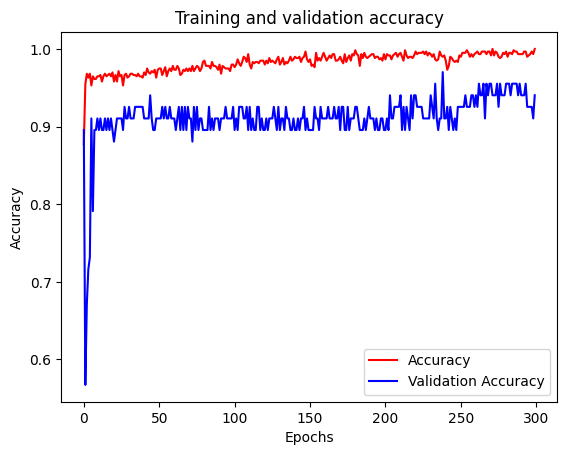

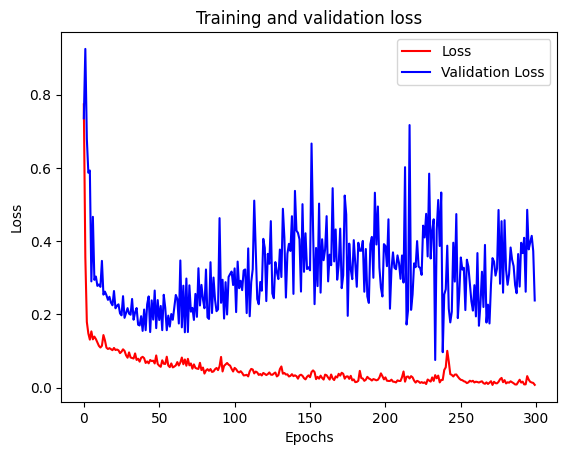

<Figure size 640x480 with 0 Axes>

In [85]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

## We will dealing with highly imbalanced datasets

In [86]:
preprocessed_data.shape

(828, 20, 157, 1)

In [98]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

n_samples, height, width, channels = preprocessed_data.shape
X_reshaped = preprocessed_data.reshape(n_samples, -1)

# Instantiate RandomOverSampler
random_oversampler = RandomOverSampler()

# Upsample the minority class using RandomOverSampler
X_resampled, y_resampled = random_oversampler.fit_resample(X_reshaped, oh_labels)
X_restored = X_resampled.reshape(-1, 20, 157, 1)


# Check the shape of the resampled data
print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)

Shape of X_resampled: (1586, 3140)
Shape of y_resampled: (1586, 1)


### Change the y_resampled to be the one-hot encoding

In [100]:
from tensorflow.keras.utils import to_categorical
y_resampled_onehot = to_categorical(y_resampled)

In [101]:
y_resampled_onehot

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [88]:
X_restored.shape

(1586, 20, 157, 1)

In [102]:
x_train, x_test, y_train, y_test = train_test_split(X_restored, y_resampled_onehot, stratify=y_resampled,
                                                    test_size=0.2, random_state = 42)

In [103]:
print("size of training set= ",len(x_train))
print("size of testing set= ",len(x_test))

size of training set=  1268
size of testing set=  318


In [104]:
y_train.shape[1]

2

In [105]:
num_rows = 20
num_columns = 157
num_channels = 1


# num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns,num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(2, activation='softmax')) # Binary Classification

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 19, 156, 16)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 9, 78, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 9, 78, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 9, 78, 64)           │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 8, 77, 32)           │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 4, 38, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 4, 38, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 4, 38, 64)           │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 3, 37, 64)           │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 1, 18, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 1, 18, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,082 (109.70 KB)

 Trainable params: 28,082 (109.70 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
# train model
num_epochs = 300
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='mymodel3_{epoch:02d}.keras',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_split=0.1, callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.4999 - loss: 6.1094
Epoch 1: val_accuracy improved from -inf to 0.82677, saving model to mymodel3_01.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 382ms/step - accuracy: 0.5012 - loss: 5.9743 - val_accuracy: 0.8268 - val_loss: 0.4963
Epoch 2/300
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6228 - loss: 0.8658
Epoch 2: val_accuracy did not improve from 0.82677
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6292 - loss: 0.8415 - val_accuracy: 0.8110 - val_loss: 0.4680
Epoch 3/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7512 - loss: 0.5387
Epoch 3: val_accuracy improved from 0.82677 to 0.91339, saving model to mymodel3_03.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7514 - loss: 0.5378 - val_accuracy: 0.9134 - val_loss: 0.3486
Epoch 4/300
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7690 - loss: 0.5154
Epoch 4: val_accuracy did not improve from 0.91339
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 

## Plotting graph

<Figure size 640x480 with 0 Axes>

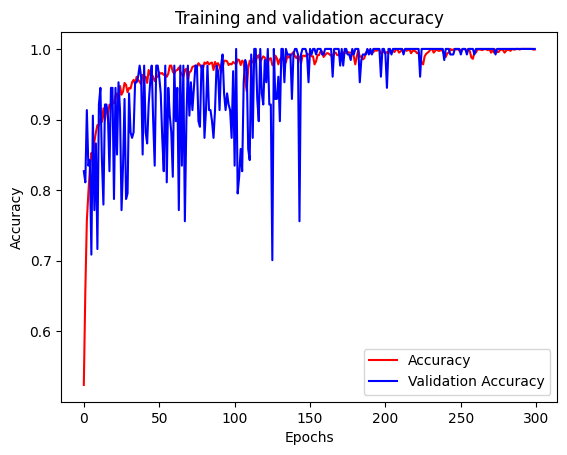

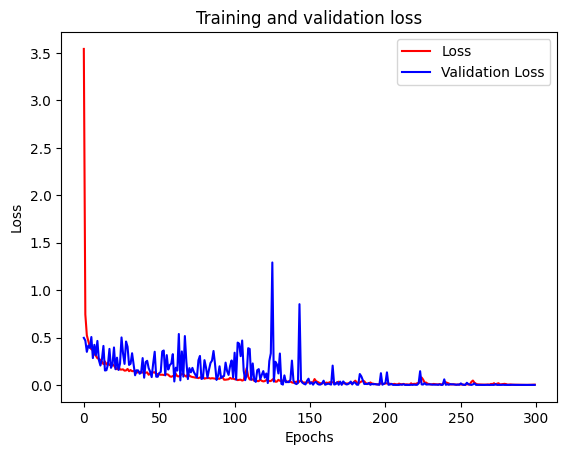

<Figure size 640x480 with 0 Axes>

In [107]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

## Model Evaluation

In [108]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  1.0
Testing Accuracy:  0.9905660152435303


## ROC AUC

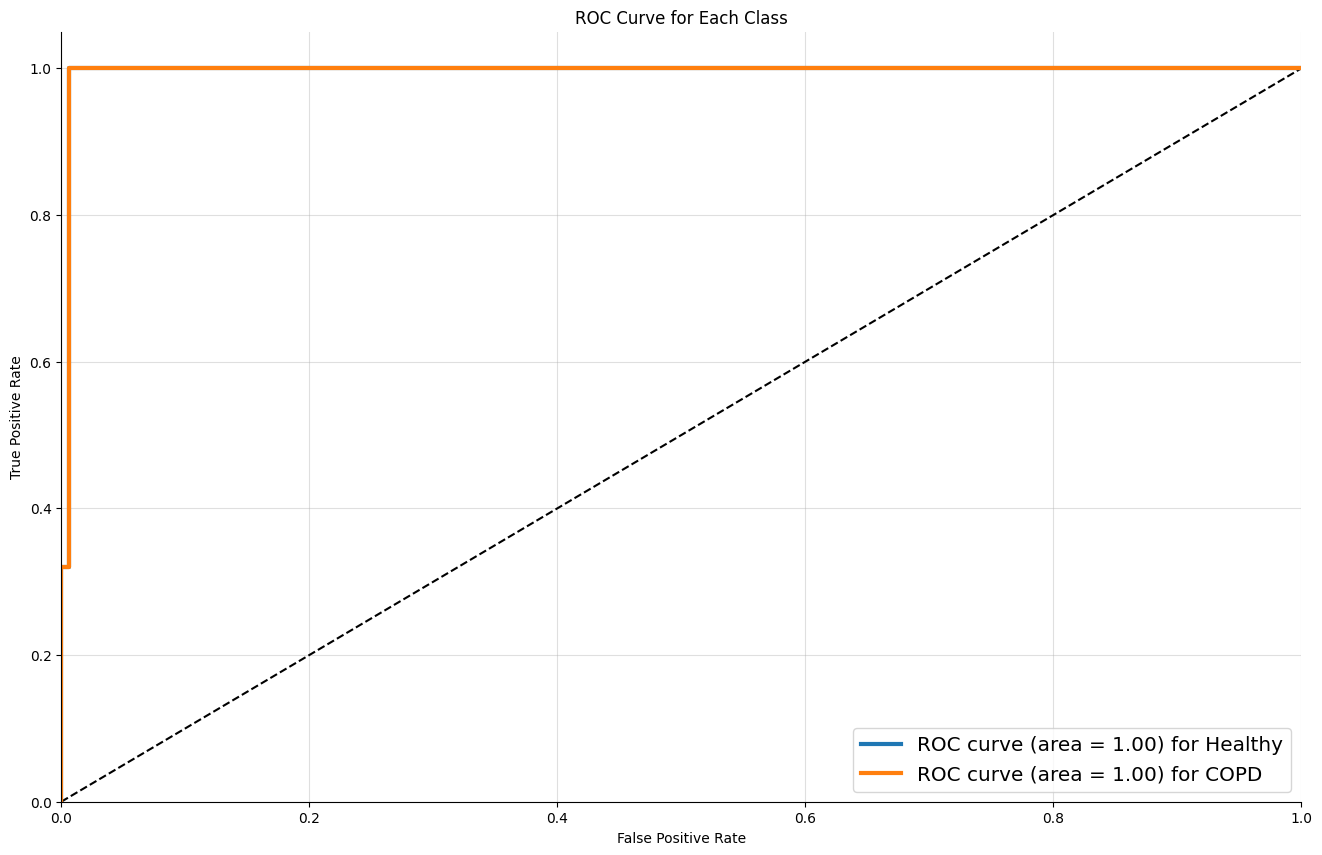

In [109]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')

# Define c_names here with your class labels
c_names = ['Healthy', 'COPD']

for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [115]:
# Predict probabilities
preds = model.predict(x_test)

# Get predicted classes (binary format)
classpreds = np.argmax(preds, axis=1)

# Get true classes (binary format)
y_testclass = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_testclass, classpreds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [116]:
y_testclass

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,

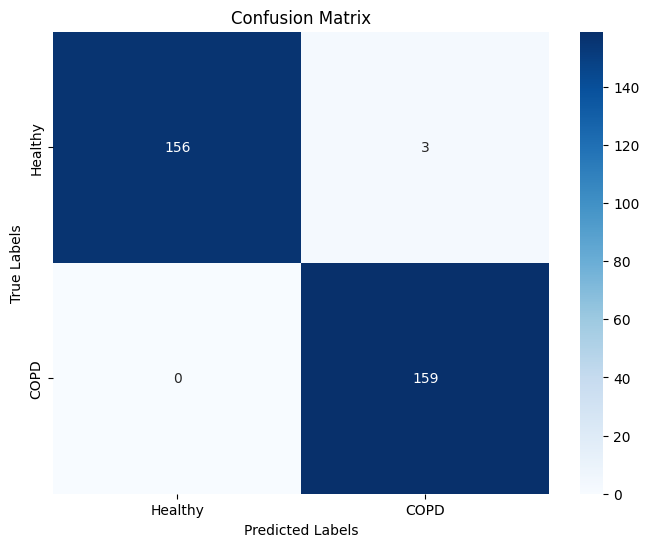

In [118]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already calculated 'classpreds' and 'y_testclass' as in the previous response

# Generate confusion matrix
cm = confusion_matrix(y_testclass, classpreds)

# Define class labels for better visualization
c_names = ['Healthy', 'COPD']

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=c_names, yticklabels=c_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [119]:
from google.colab import files
files.download('mymodel3_102.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

## Trying the model

In [120]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model
from google.colab import files

# Function to preprocess the audio file
def preprocessing(audio_file, mode):
    sr_new = 16000
    x, sr = librosa.load(audio_file, sr=sr_new)
    max_len = 5 * sr_new
    if x.shape[0] < max_len:
        pad_width = max_len - x.shape[0]
        x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
        x = x[:max_len]
    if mode == 'mfcc':
        feature = librosa.feature.mfcc(y=x, sr=sr_new)
    elif mode == 'log_mel':
        feature = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
        feature = librosa.power_to_db(feature, ref=np.max)
    return feature

# Upload the audio file
uploaded = files.upload()
audio_file_name = list(uploaded.keys())[0]

# Preprocess the uploaded audio
preprocessed_audio = preprocessing(audio_file_name, mode='mfcc')

# Reshape the data
preprocessed_audio = preprocessed_audio.reshape((1, 20, 157, 1))

# Load the model (replace 'mymodel3_102.keras' with your actual model file)
model = load_model('mymodel3_102.keras')

# Make a prediction
prediction = model.predict(preprocessed_audio)

# Get the predicted class
predicted_class = np.argmax(prediction, axis=1)

# Print the prediction (assuming classes are 'Healthy' and 'COPD')
class_labels = ['Healthy', 'COPD']
print(f"Predicted class: {class_labels[predicted_class[0]]}")

Saving 101_1b1_Al_sc_Meditron.wav to 101_1b1_Al_sc_Meditron.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
Predicted class: Healthy
